# Capstone Project - The Battle of Neighborhoods (Week 1)

## Table of contents
* **Introduction: Business Problem**
* **Data**
* **Methodology and Analysis**
* **Results**
* **Discussion**
* **Conclusion**

# 1- Introduction: Business Problem <a name="introduction"></a>

#### Where you discuss the business problem and who would be interested in this project.

**Description :** In this project we will try to find an optimal location for a restaurant specialized in Dominican Food, the stakeholders owns two locations in Patterson NJ(USA) already, but she is interested in expanding her business to another state, in this case Georgia.

**Background:** The stakeholder knows there is a lot of people traveling through Georgia, due to Atlanta having an international airport, and being a busy city, she wants to make sure to get an ideal place, not too far from the airport, and where this type of restaurant is not common.  

We will use our Data Science skills to find the ideal place that meets with these criteria, close to the airport, and in an area where restaurants are common, but here are not Dominican Restaurants yet, is OK any other type of Caribbean restaurants.

# 2- Data <a name="data"></a>

We were given 3 specific cities closed to the Airport to look into (**Atlanta, Decatur and Kennesaw**), and then select the best place for our Dominican Restaurant.  

- First I used Foresquare API to collect the venues within 10 miles of each city center.  
- Second I filtered the results and collected just the restaurants found within 10 miles of each city center.

- Third I performed a search to make sure there were no other Dominican restaurants in the area.

- Finally, I generated a plot with each restaurant found in each city center, to have a visual of how close are these restaurants to each other, this will give us an overview of the data that we're working with to find the best city to place our Dominican Restaurant.

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
from folium.plugins import MarkerCluster

In [2]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


def json_to_dataframe(items):
    dataframe = json_normalize(items) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories'] + [col for col in dataframe.columns if col.startswith('venue.location.')] + ['venue.id']
    dataframe_filtered = dataframe.loc[:, filtered_columns]

    # filter the category for each row
    dataframe_filtered['venue.categories'] = dataframe_filtered.apply(get_category_type, axis=1)

    # clean columns
    dataframe_filtered.columns = [col.split('.')[-1] for col in dataframe_filtered.columns]

    return dataframe_filtered

**Fourtsquare Credentials**

In [3]:
# Fourtsquare Credentials
CLIENT_ID = '0SNZYNIMMXS2QECV0POPXLWQNXYC4DIPSFARJEYD1TBSCLTA' # your Foursquare ID
CLIENT_SECRET = 'SEZBRZ1VRC0PKCUTBSZUXTS021LBV5TZLIBU2UJX1YW5KM1H' # your Foursquare Secret
VERSION = '20180604'
RADIUS = 16093.4  # 10 miles
LIMIT = 100
# print('Your credentails:')
# print('CLIENT_ID: ' + CLIENT_ID)
# print('CLIENT_SECRET:' + CLIENT_SECRET)

### Exploring our 3 locations

**Atlanta Data Collection**

In [4]:
# Atlanta Coordinates
atlanta = {'lat':33.749, 'lng':-84.388}

# Atlanta URL to perform venew search
url_atlanta = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, atlanta['lat'], atlanta['lng'], VERSION, RADIUS, LIMIT)
results_atlanta = requests.get(url_atlanta).json()


# Collecting venue items into a DataFrame
items_atlanta = results_atlanta['response']['groups'][0]['items']
df_atlanta = json_to_dataframe(items_atlanta)

'There are {} venues within 10 miles of Atlanta center.'.format(len(results_atlanta['response']['groups'][0]['items']))

'There are 100 venues within 10 miles of Atlanta center.'

In [5]:
# Collecting restaurants in our Dataframe
df_atl_rest = df_atlanta[df_atlanta["categories"].str.contains('Restaurant')]
df_atl_rest.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
0,Aviva by Kameel,Mediterranean Restaurant,225 Peachtree St NE,US,Atlanta,United States,In the Mall at Peachtree Center,1297,[225 Peachtree St NE (In the Mall at Peachtree...,"[{'label': 'display', 'lat': 33.7605969735783,...",33.760597,-84.386548,NaN,30303,GA,50731cc9e4b06489e10a354d
3,Nick's Food To Go,Greek Restaurant,240 MLK Dr SE,US,Atlanta,United States,at Hill St,781,"[240 MLK Dr SE (at Hill St), Atlanta, GA 30312...","[{'label': 'display', 'lat': 33.7474921065436,...",33.747492,-84.379749,NaN,30312,GA,4abbf3d9f964a520a28520e3
25,Atlanta Breakfast Club,American Restaurant,249 Ivan Allen Jr Blvd NW,US,Atlanta,United States,at Venable St NW,1888,"[249 Ivan Allen Jr Blvd NW (at Venable St NW),...","[{'label': 'display', 'lat': 33.76479891528359...",33.764799,-84.395432,NaN,30313,GA,53298b6b498e04fb57694aae
31,Superica,Mexican Restaurant,99 Krog St NE,US,Atlanta,United States,NaN,2367,"[99 Krog St NE, Atlanta, GA 30307, United States]","[{'label': 'display', 'lat': 33.75700282446537...",33.757003,-84.364299,NaN,30307,GA,54deafbf498eab5eadfd5319
32,Poor Calvin's,Thai Restaurant,510 Piedmont Ave NE,US,Atlanta,United States,Renaissance Pkwy. NE,2223,"[510 Piedmont Ave NE (Renaissance Pkwy. NE), A...","[{'label': 'display', 'lat': 33.7684, 'lng': -...",33.768400,-84.382260,NaN,30308,GA,50a570e38aca7f0bfeca898c


In [6]:
# Amount of restaurants found within 10 miles of Atlanta center.
df_atl_rest["categories"].count()

23

In [7]:
# Amount of restaurants with the word Dominican in their name found within 10 miles of Atlanta center.
df_atl_rest["categories"][df_atl_rest["categories"].str.contains('Dominican|Dominicano')].count()

0

In [8]:
atlanta_map = folium.Map(location=[atlanta['lat'], atlanta['lng']], zoom_start=13)

# Add restaurants to the map
for lat, lng, label in zip(df_atl_rest.lat, df_atl_rest.lng, df_atl_rest.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='yellow',
        fill_opacity=0.6
        ).add_to(atlanta_map)

# display map
atlanta_map

**Decatur Data Collection**

In [9]:
decatur = {'lat':33.774, 'lng':-84.296}

# Decatur URL to perform venew search
url_decatur = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, decatur['lat'], decatur['lng'], VERSION, RADIUS, LIMIT)
results_decatur = requests.get(url_decatur).json()

# Collecting venue items into a DataFrame
items_decatur = results_decatur['response']['groups'][0]['items']
df_decatur = json_to_dataframe(items_decatur)

'There are {} venues within 10 miles of Decatur center.'.format(len(results_decatur['response']['groups'][0]['items']))

'There are 100 venues within 10 miles of Decatur center.'

In [10]:
# Collecting restaurants in our Dataframe
df_dec_rest = df_decatur[df_decatur["categories"].str.contains('Restaurant')]
df_dec_rest.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,neighborhood,postalCode,state,id
1,The Iberian Pig,Spanish Restaurant,121 Sycamore St,US,Decatur,United States,NaN,42,"[121 Sycamore St, Decatur, GA 30030, United St...","[{'label': 'display', 'lat': 33.77438, 'lng': ...",33.774380,-84.296000,NaN,30030,GA,4aa2b2f8f964a520164220e3
4,No. 246,Italian Restaurant,129 E Ponce de Leon Ave,US,Decatur,United States,btwn Church St & E Court Sq,181,[129 E Ponce de Leon Ave (btwn Church St & E C...,"[{'label': 'display', 'lat': 33.77553761696676...",33.775538,-84.295349,NaN,30030,GA,4daf0acab3dcd1a46a0b5e57
10,The Pinewood,American Restaurant,254 W Ponce de Leon Ave,US,Decatur,United States,at Ponce de Leon Pl.,401,[254 W Ponce de Leon Ave (at Ponce de Leon Pl....,"[{'label': 'display', 'lat': 33.77548088894041...",33.775481,-84.299958,Downtown Decatur,30030,GA,4fa5cb03e4b094b946a36158
13,Las Brasas,South American Restaurant,614 Church St,US,Decatur,United States,near Commerce Dr,477,"[614 Church St (near Commerce Dr), Decatur, GA...","[{'label': 'display', 'lat': 33.77822440726790...",33.778224,-84.295098,NaN,30030,GA,49dd2c1ef964a520ef5f1fe3
27,Madras Mantra,South Indian Restaurant,2179 Lawrenceville Hwy Ste A,US,Decatur,United States,NaN,4673,"[2179 Lawrenceville Hwy Ste A, Decatur, GA 300...","[{'label': 'display', 'lat': 33.81060798417284...",33.810608,-84.271270,NaN,30033,GA,55679b78498efa7eb6a22221


In [11]:
# Amount of restaurants found within 10 miles of Atlanta center.
df_dec_rest["categories"].count()

20

In [12]:
# Amount of restaurants with the word Dominican in their name found within 10 miles of Atlanta center.
df_dec_rest["categories"][df_dec_rest["categories"].str.contains('Dominican|Dominicano')].count()

0

In [13]:
decatur_map = folium.Map(location=[decatur['lat'], decatur['lng']], zoom_start=13)

# Add restaurants to the map
for lat, lng, label in zip(df_dec_rest.lat, df_dec_rest.lng, df_dec_rest.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='yellow',
        fill_opacity=0.6
        ).add_to(decatur_map)

# display map
decatur_map

**Kennesaw Data Collection**

In [14]:
kennesaw = {'lat':34.023, 'lng':-84.615}

# Atlanta URL to perform venew search
url_kennesaw = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, kennesaw['lat'], kennesaw['lng'], VERSION, RADIUS, LIMIT)
results_kennesaw = requests.get(url_kennesaw).json()


# Collecting venue items into a DataFrame
items_kennesaw = results_kennesaw['response']['groups'][0]['items']
df_kennesaw = json_to_dataframe(items_kennesaw)

'There are {} venues within 10 miles of Kennesaw center.'.format(len(results_kennesaw['response']['groups'][0]['items']))

'There are 100 venues within 10 miles of Kennesaw center.'

In [15]:
# Collecting restaurants in our Dataframe
df_ken_rest = df_kennesaw[df_kennesaw["categories"].str.contains('Restaurant')]
df_ken_rest.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
13,Capers,American Restaurant,1659-1705 Old U.S. 41 NW,US,Acworth-Kennesaw,United States,NaN,3555,"[1659-1705 Old U.S. 41 NW, Acworth-Kennesaw, G...","[{'label': 'display', 'lat': 33.99405415284648...",33.994054,-84.598705,30152,GA,4b857420f964a520f75e31e3
16,Carrabba's Italian Grill,Italian Restaurant,1160 Ernest W Barrett Pkwy NW,US,Kennesaw,United States,NaN,3785,"[1160 Ernest W Barrett Pkwy NW, Kennesaw, GA 3...","[{'label': 'display', 'lat': 34.00108100441834...",34.001081,-84.583639,30144,GA,4b2abebdf964a520bcae24e3
19,Marlow's Tavern,New American Restaurant,"745 Chastain Road NW, Suite 1160",US,Kennesaw,United States,at George Busbee Pkwy,4274,"[745 Chastain Road NW, Suite 1160 (at George B...","[{'label': 'display', 'lat': 34.0348057, 'lng'...",34.034806,-84.570914,30144,GA,4a7cbf12f964a52073ed1fe3
21,Copeland's of New Orleans,Cajun / Creole Restaurant,1142 Ernest W Barrett Pkwy NW,US,Kennesaw,United States,at Roberts Blvd NW,3811,[1142 Ernest W Barrett Pkwy NW (at Roberts Blv...,"[{'label': 'display', 'lat': 34.00161679569724...",34.001617,-84.582746,30144,GA,4ab0469ff964a520ca6620e3
22,Chick-fil-A,Fast Food Restaurant,830 Ernest W Barrett Pkwy Nw,US,Kennesaw,United States,NaN,4182,"[830 Ernest W Barrett Pkwy Nw, Kennesaw, GA 30...","[{'label': 'display', 'lat': 34.0070494, 'lng'...",34.007049,-84.573964,30144,GA,4b4bd76af964a52049a926e3


In [16]:
# Amount of restaurants found within 10 miles of Atlanta center.
df_ken_rest["categories"].count()

30

In [17]:
# Amount of restaurants with the word Dominican in their name found within 10 miles of Atlanta center.
df_ken_rest["categories"][df_ken_rest["categories"].str.contains('Dominican|Dominicano')].count()

0

In [18]:
kennesaw_map = folium.Map(location=[kennesaw['lat'], kennesaw['lng']], zoom_start=13) 
# Add restaurants to the map
for lat, lng, label in zip(df_ken_rest.lat, df_ken_rest.lng, df_ken_rest.categories):
    folium.features.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        fill=True,
        color='blue',
        fill_color='yellow',
        fill_opacity=0.6
        ).add_to(kennesaw_map)

# display map
kennesaw_map

<hr size=30px></hr>

# Capstone Project - The Battle of Neighborhoods (Week 2)

# 3- Methodology and Analysis

### Section which represents the main component of the report where you discuss and describe any exploratory data analysis that you did, any inferential statistical testing that you performed, if any, and what machine learnings were used and why.

I applied the same analytics and Model implementation to each city, to understand how close are the restaurants in relationship to each city center and the proximity between restaurants.

**First** - I grouped the restaurants by categories and distance to understand the types of restaurants I was dealing with, the variety of restaurants in the areas, and how far are these located form the city center.

**Second** - I filtered how many restaurants were within 2 miles of each city center, just to get an overview of the locations and amount of restaurants close to the city centers.

**Third** - I plotted the restaurants by categories and distance from the city centers, to get a visual of the distance for each restaurant we found for each city.

**Fourth** - I ran a Kmeans cluster on each city to get a visual of the restaurant's density, also plot a cluster on each city map.

**Atlanta restaurant exploration data.**

In [19]:
# Restaurants grouped by Category and Distance
pd.DataFrame(df_atl_rest.groupby(['categories','distance'])['categories'].count())

categories
categories                      distance            
American Restaurant             1888               1
                                2505               1
                                3292               1
                                3790               1
Asian Restaurant                4133               1
Cuban Restaurant                2743               1
Fast Food Restaurant            3700               1
French Restaurant               3679               1
Greek Restaurant                781                1
Italian Restaurant              4324               1
Mediterranean Restaurant        1297               1
                                3325               1
                                3569               1
Mexican Restaurant              2367               1
                                3109               1
                                3853               1
Restaurant                      2919               1
Seafood Restaurant              4024               1
Southern / Soul Food Restaurant 2977               1
                                4129               1
Thai Restaurant                 2223               1
Vegetarian / Vegan Restaurant   2361               1
Vietnamese Restaurant           3789               1

In [20]:
# Restaurants in less than 2 miles around the center
df_atl_rest[['categories', 'distance']][df_atl_rest['distance'] < 3300].count()

categories    12
distance      12
dtype: int64

In [21]:
# Restaurants in less than 2 miles around the center
df_atl_rest[['categories', 'distance']][df_atl_rest['distance'] < 3300]

,categories,distance
0,Mediterranean Restaurant,1297
3,Greek Restaurant,781
25,American Restaurant,1888
31,Mexican Restaurant,2367
32,Thai Restaurant,2223
36,American Restaurant,2505
40,Vegetarian / Vegan Restaurant,2361
44,Mexican Restaurant,3109
45,Restaurant,2919
51,Cuban Restaurant,2743


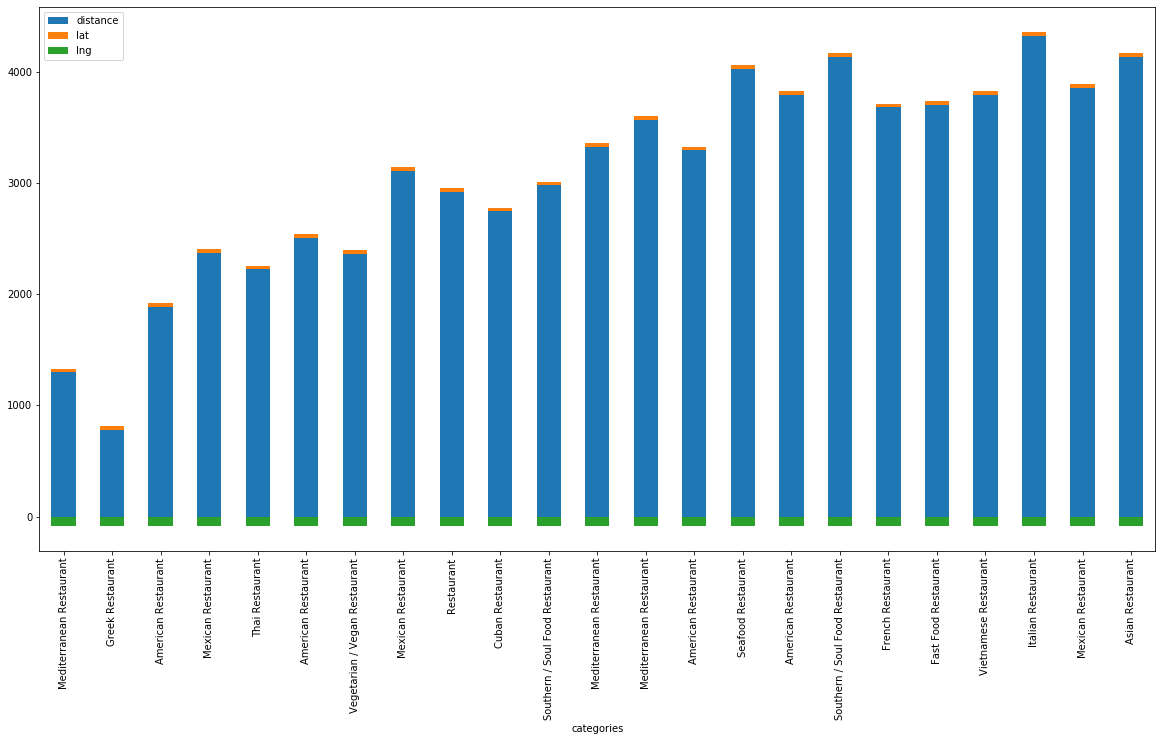

In [22]:
df_atl_rest.plot(x='categories',kind='bar', figsize=(20, 10), stacked=True )

/home/jrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Silhouette Score: 0.4833584046505372


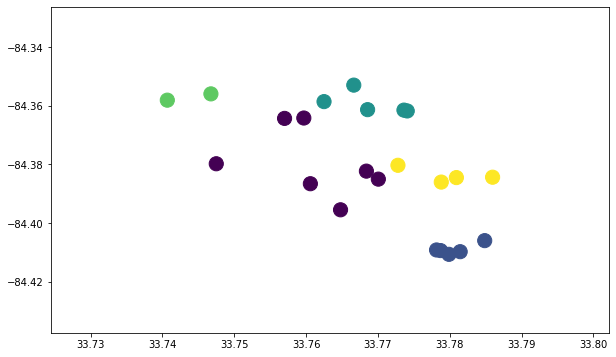

In [23]:
X = df_atl_rest[['distance', 'lat', 'lng', 'postalCode']]
X = StandardScaler().fit(X).transform(X.astype(float))

kmeans_model = KMeans(n_clusters=5, random_state=20, max_iter=25).fit(X)
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_
score = metrics.silhouette_score(X, kmeans_model.labels_, metric='euclidean')
print(f'Silhouette Score: {score}')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_atl_rest['lat'], df_atl_rest['lng'], s=200, c=labels, cmap='viridis')
plt.show()

In [24]:
atlanta_map = folium.Map(location=[atlanta['lat'], atlanta['lng']], zoom_start=13)

mc = MarkerCluster()

#creating a Marker for each point 
for row in df_atl_rest.itertuples():
    mc.add_child(folium.Marker(location=[row.lat,  row.lng],
                 popup=row.categories))

atlanta_map.add_child(mc)


atlanta_map

**Decatur restaurant exploration data.**

In [25]:
# Restaurants grouped by Category and Distance
pd.DataFrame(df_dec_rest.groupby(['categories','distance'])['categories'].count())

categories
categories                      distance            
American Restaurant             401                1
                                5334               1
                                5501               1
                                5787               1
                                6074               1
                                6506               1
Ethiopian Restaurant            7225               1
Fast Food Restaurant            6085               1
French Restaurant               6059               1
Hawaiian Restaurant             5993               1
Italian Restaurant              181                1
                                5518               1
Mexican Restaurant              5931               1
                                6597               1
Restaurant                      6839               1
South American Restaurant       477                1
South Indian Restaurant         4673               1
Southern / Soul Food Restaurant 6323               1
Spanish Restaurant              42                 1
Thai Restaurant                 5252               1

In [26]:
# Restaurants in less than 2 miles around the center
df_dec_rest[['categories', 'distance']][df_dec_rest['distance'] < 3300].count()

categories    4
distance      4
dtype: int64

In [27]:
# Restaurants in less than 2 miles around the center
df_dec_rest[['categories', 'distance']][df_dec_rest['distance'] < 3300]

,categories,distance
1,Spanish Restaurant,42
4,Italian Restaurant,181
10,American Restaurant,401
13,South American Restaurant,477


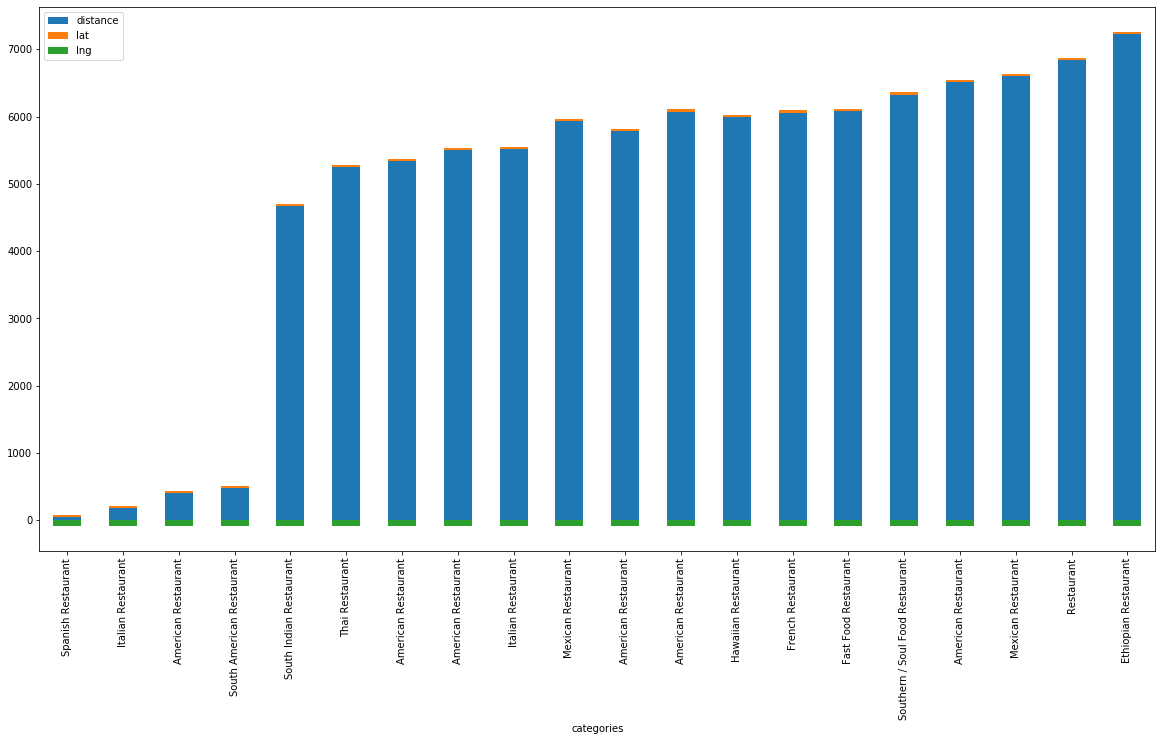

In [28]:
df_dec_rest.plot(x='categories',kind='bar', figsize=(20, 10), stacked=True )

/home/jrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Silhouette Score: 0.5918779224879334


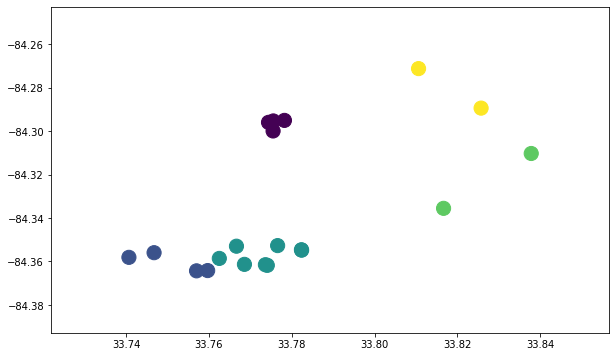

In [29]:
X = df_dec_rest[['distance', 'lat', 'lng', 'postalCode']]
X = StandardScaler().fit(X).transform(X.astype(float))

kmeans_model = KMeans(n_clusters=5, random_state=20, max_iter=25).fit(X)
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_
score = metrics.silhouette_score(X, kmeans_model.labels_, metric='euclidean')
print(f'Silhouette Score: {score}')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_dec_rest['lat'], df_dec_rest['lng'], s=200, c=labels, cmap='viridis')
plt.show()

In [30]:
decatur_map = folium.Map(location=[decatur['lat'], decatur['lng']], zoom_start=12)

mc = MarkerCluster()

#creating a Marker for each point 
for row in df_dec_rest.itertuples():
    mc.add_child(folium.Marker(location=[row.lat,  row.lng],
                 popup=row.categories))

decatur_map.add_child(mc)


decatur_map

**Kennesaw restaurant exploration data.**

In [31]:
# Restaurants grouped by Category and Distance
pd.DataFrame(df_ken_rest.groupby(['categories','distance'])['categories'].count())

categories
categories                      distance            
American Restaurant             3555               1
                                3845               1
                                4130               1
Asian Restaurant                3980               1
Cajun / Creole Restaurant       3811               1
                                7510               1
Caribbean Restaurant            4302               1
Chinese Restaurant              4103               1
Cuban Restaurant                4246               1
Fast Food Restaurant            4182               1
                                4459               1
                                6012               1
                                8688               1
Greek Restaurant                4090               1
Italian Restaurant              3785               1
                                4912               1
                                7453               1
Korean Restaurant               8181               1
Malay Restaurant                4648               1
Mexican Restaurant              4436               1
                                5831               1
                                6087               1
                                6159               1
                                8418               1
New American Restaurant         4274               1
Seafood Restaurant              5408               1
Southern / Soul Food Restaurant 5066               1
                                7427               1
Sushi Restaurant                3897               1
Thai Restaurant                 7527               1

In [32]:
# Restaurants in less than 2 miles around the center
df_ken_rest[['categories', 'distance']][df_ken_rest['distance'] < 3300].count()

categories    0
distance      0
dtype: int64

In [33]:
# Restaurants in less than 2 miles around the center
df_ken_rest[['categories', 'distance']][df_ken_rest['distance'] < 3300]

,categories,distance


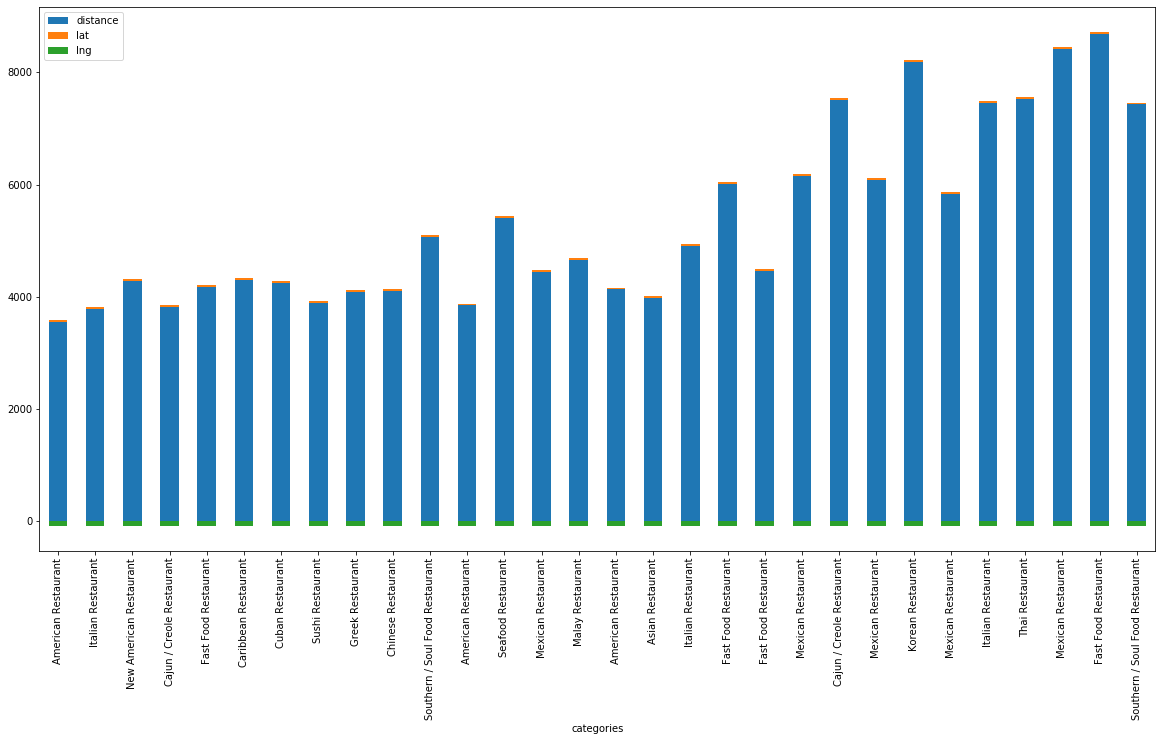

In [34]:
df_ken_rest.plot(x='categories',kind='bar', figsize=(20, 10), stacked=True )

In [35]:
df_ken_rest_clean = df_ken_rest[['distance', 'lat', 'lng', 'postalCode']].copy()

In [36]:
df_ken_rest_clean.dropna(inplace=True)

/home/jrodriguez/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64, object were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Silhouette Score: 0.6220912730227707


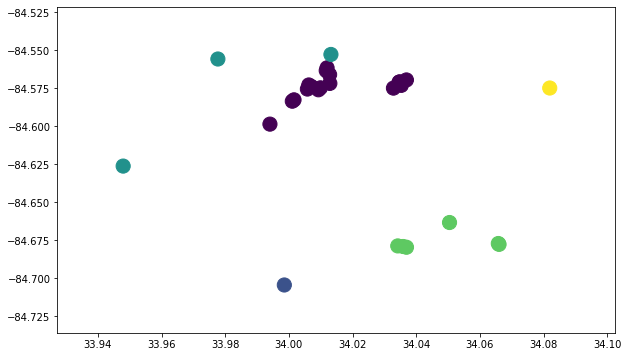

In [37]:
X = df_ken_rest_clean
X = StandardScaler().fit(X).transform(X.astype(float))

kmeans_model = KMeans(n_clusters=5, random_state=20, max_iter=25).fit(X)
labels = kmeans_model.labels_
centers = kmeans_model.cluster_centers_
score = metrics.silhouette_score(X, kmeans_model.labels_, metric='euclidean')
print(f'Silhouette Score: {score}')

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(df_ken_rest_clean['lat'], df_ken_rest_clean['lng'], s=200, c=labels, cmap='viridis')
plt.show()

In [38]:
kennesaw_map = folium.Map(location=[kennesaw['lat'], kennesaw['lng']], zoom_start=12)

mc = MarkerCluster()

#creating a Marker for each point 
for row in df_ken_rest.itertuples():
    mc.add_child(folium.Marker(location=[row.lat,  row.lng],
                 popup=row.categories))

kennesaw_map.add_child(mc)


kennesaw_map

# 4- Results

### Section where you discuss the results.

### **Atlanta:**

These are all the type of restaurants we found in the area of Atlanta within 10 miles from the city center.

In [39]:
df_atl_rest.groupby(['categories'])['categories'].count()

categories
American Restaurant                4
Asian Restaurant                   1
Cuban Restaurant                   1
Fast Food Restaurant               1
French Restaurant                  1
Greek Restaurant                   1
Italian Restaurant                 1
Mediterranean Restaurant           3
Mexican Restaurant                 3
Restaurant                         1
Seafood Restaurant                 1
Southern / Soul Food Restaurant    2
Thai Restaurant                    1
Vegetarian / Vegan Restaurant      1
Vietnamese Restaurant              1
Name: categories, dtype: int64

Within 2 miles from the city center, we found 12 restaurants.

In [40]:
df_atl_rest[['categories', 'distance']][df_atl_rest['distance'] < 3300].count()

categories    12
distance      12
dtype: int64

From the 12 restaurants the further one is Vegetarian / Vegan Restaurant, located 3292 meters from the city center.

In [41]:
df_atl_rest[['categories', 'distance']][df_atl_rest['distance'] < 3300].max()

categories    Vegetarian / Vegan Restaurant
distance                               3292
dtype: object

The closes one is an American Restaurant, located within 781 meters from the city center.

In [42]:
df_atl_rest[['categories', 'distance']][df_atl_rest['distance'] < 3300].min()

categories    American Restaurant
distance                      781
dtype: object

### **Decatur**

These are all the type of restaurants we found in the area of Decatur within 10 miles from the city center.

In [43]:
df_dec_rest.groupby(['categories'])['categories'].count()

categories
American Restaurant                6
Ethiopian Restaurant               1
Fast Food Restaurant               1
French Restaurant                  1
Hawaiian Restaurant                1
Italian Restaurant                 2
Mexican Restaurant                 2
Restaurant                         1
South American Restaurant          1
South Indian Restaurant            1
Southern / Soul Food Restaurant    1
Spanish Restaurant                 1
Thai Restaurant                    1
Name: categories, dtype: int64

Within 2 miles from the city center, we found 4 restaurants.

In [44]:
df_dec_rest[['categories', 'distance']][df_dec_rest['distance'] < 3300].count()

categories    4
distance      4
dtype: int64

From the 4 restaurants the further one is Spanish Restaurantt, located 477 meters from the city center.

In [45]:
df_dec_rest[['categories', 'distance']][df_dec_rest['distance'] < 3300].max()

categories    Spanish Restaurant
distance                     477
dtype: object

The closes one is an American Restaurant, located within 42 meters from the city center.

In [46]:
df_dec_rest[['categories', 'distance']][df_dec_rest['distance'] < 3300].min()

categories    American Restaurant
distance                       42
dtype: object

### Kennesaw

These are all the type of restaurants we found in the area of Kennesaw within 10 miles away from the city center.

In [47]:
df_ken_rest.groupby(['categories'])['categories'].count()

categories
American Restaurant                3
Asian Restaurant                   1
Cajun / Creole Restaurant          2
Caribbean Restaurant               1
Chinese Restaurant                 1
Cuban Restaurant                   1
Fast Food Restaurant               4
Greek Restaurant                   1
Italian Restaurant                 3
Korean Restaurant                  1
Malay Restaurant                   1
Mexican Restaurant                 5
New American Restaurant            1
Seafood Restaurant                 1
Southern / Soul Food Restaurant    2
Sushi Restaurant                   1
Thai Restaurant                    1
Name: categories, dtype: int64

No restaurants where found within 2 miles from the city center.

In [48]:
df_ken_rest[['categories', 'distance']][df_ken_rest['distance'] < 3300].count()

categories    0
distance      0
dtype: int64

### 5- Discussion section where you discuss any observations you noted and any recommendations you can make based on the results.

Base on the Data Analysis and after implementing clusters to the restaurants for each city, there are some interesting things to pay attention to. 

Our Stakeholder wants to open the restaurant in one of these 3 cities because they are closer to the Atlanta Airport, which may attract a new type of customers to the restaurant.

Base on the observation, Atlanta besides being closer to the airport, has more variety of restaurants, but even though it has the biggest variety, it does not have a Dominican restaurant nearby, which gives us a good advantage.

We could see that in Atlanta the restaurants are closer to each other, making it easier for the customer to find out about the Dominican Restaurant while visiting another one, or even while visiting another type of venneu, with Atlanta having 12 restaurants within two miles of the city center, while Decatur had 4 and Kennesaw none, this tells us that Atlanta is a walking city, which might impact the number of people visiting the restaurant.

The last thing we could perceive base on the clustering process was, how close where the restaurants in relationship to another restaurant, also we got the closer clusters in Atlanta, then Decatur and Kennesaw had sparse clusters, which means there is a high chance that if a customer visits a restaurant in one of these cities, they might not see the Dominican restaurant while wondering on the nearby areas, not as if they were in Atlanta, base on the clusters information.

### 6- Conclusion section where you conclude the report.

In conclusion, due to the probabilities of getting new customers, the good place within walking distance from other restaurants, the variety of restaurants, which could decide that in this city we might see a big variety of customers with different likes that might be interested in trying food from the Dominican Restaurant, taking in consideration that it will be the first restaurant offering this type of food in the area, and the fact that is the closes city to the Airport, in conclusion,  Atlanta is the best city from the 3 cities provided by our Stakeholder, if she wants to open a Dominican restaurant in Georgia.